In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

/root/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [5]:
# generate dataset 

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Data intuition

A simple example that shows how the dataset generates context for each character

In [6]:
w = "emilia"
block_size = 3
X = []
Y = []

context = [0] * block_size
for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)

    # setup context for next iteration
    # slide context by 1 and add current character 
    # [0, 0 ,0] --> e
    # [0, 0, e] --> m
    # [0, e, m] --> i
    # [e, m, i] --> l
    # [m, i, l] --> i
    # [i, l, i] --> a
    context = context[1:] + [ix]

# Poor man implementation of network

This section shows a simple implementation of a network with batchnorm. 

In [7]:
# Dataset dimensions
Xtr.shape # 182580, 3 
Ytr.shape # 182580

torch.Size([182625])

In [8]:
# Set generator
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# MLP - embedding layer
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [9]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # generate mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # Embedding layer
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839


KeyboardInterrupt: 

# Pytorchify code

This section tries to pytorchify the code so the network looks a lot more like pytorch. 

### Define layer classes

In [92]:
class Linear: 
    def __init__(self, fan_in, fan_out, bias=True):
        self.bias = bias 
        self.weight = torch.randn(fan_in, fan_out, generator=g) / fan_in ** 0.5
        self.b = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        if self.bias: 
            self.out = x @ self.weight + self.b
        else:
            self.out = x * self.weight
        
        return self.out

    def parameters(self):
        return [self.weight, self.b] if self.bias else [self.weight]

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.dim = dim
        self.eps = eps
        self.momentum = momentum

        self.gamma = torch.randn(dim)
        self.beta = torch.randn(dim)

        self.running_mean = torch.zeros(dim)
        self.running_std = torch.ones(dim)

    def __call(self, x):
        if self.training:
            # calculate batch statistics
            batch_mean = x.mean(0, keepdim=True)
            batch_var = x.var(0, keepdim=True)

            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * batch_mean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * batch_var

        else:
            batch_mean = self.running_mean
            batch_std = self.running_std
        
        xhat = (x - batch_mean) / torch.sqrt(batch_var + self.eps) ** 0.5
        self.out = self.gamma * xhat + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

### Setup NN layers

In [97]:
# setup NN parameters

# generator
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# NN parameters
n_vocab = vocab_size
n_embd = 10 
n_hidden = 100

# define pytorch layers
C = torch.randn(vocab_size, n_embd)
layers = [
    # stacked layers
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),

    # logits layer
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1 

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3  # Ensure layer.weight modification correctly applies only to tensors
    
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


46497


### Setup optimization loop

In [101]:
# Correct optimization loop
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # generate mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # embed input
    emb = C[Xb] # embed input
    x = emb.view(emb.shape[0], -1) # reshape dimensions

    # forward pass
    for layer in layers:
        x = layer(x)

    # loss calculation
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        if hasattr(layer, 'out'):
            layer.out.retain_grad()
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters
    learning_rate = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -learning_rate * p.grad
      
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/  20000: 3.3224


# Visualizations

These are diagnostic tools that Karpathy has introduced us for understanding whether or not the network is updating properly based on our optimization parameters and initialization of weights. It's a way to quickly introspect the network and find if there are things that are wrong. 

layer 1 (      Tanh): mean +0.01, std 0.77, saturated: 20.81%
layer 3 (      Tanh): mean -0.02, std 0.72, saturated: 12.91%
layer 5 (      Tanh): mean +0.05, std 0.72, saturated: 12.50%
layer 7 (      Tanh): mean +0.03, std 0.74, saturated: 12.97%
layer 9 (      Tanh): mean +0.01, std 0.71, saturated: 11.41%


Text(0.5, 1.0, 'activation distribution')

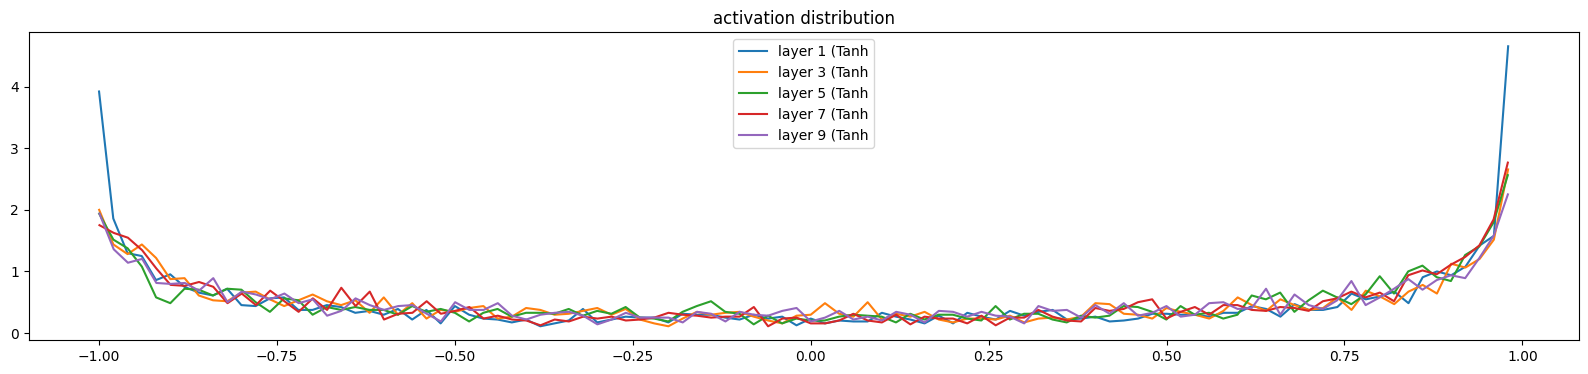

In [103]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')

plt.legend(legends);
plt.title('activation distribution')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0129c86c-0221-47a9-9ff5-5a790f5a7462' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>